# Excercise  7

In [1]:
# Imports
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.stats import norm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from sklearn.metrics import accuracy_score, fbeta_score, make_scorer, roc_auc_score

In [2]:
Dataset = sio.loadmat('HW8.mat')
train_x = Dataset['train_x']
train_y= Dataset['train_y']

test_x = Dataset['test_x']
test_y = Dataset['test_y']

df = pd.DataFrame(np.hstack((train_x, train_y)), columns = ['X1', 'X2', 'y'])
y_1 = df[['X1', 'X2']].loc[ df.y == 1].to_numpy()
y_2 = df[['X1', 'X2']].loc[ df.y == 2].to_numpy()

df_test = pd.DataFrame(np.hstack((test_x, test_y)), columns = ['X1', 'X2', 'y'])
y_1_test = df_test[['X1', 'X2']].loc[ df_test.y == 1].to_numpy()
y_2_test = df_test[['X1', 'X2']].loc[ df_test.y == 2].to_numpy()

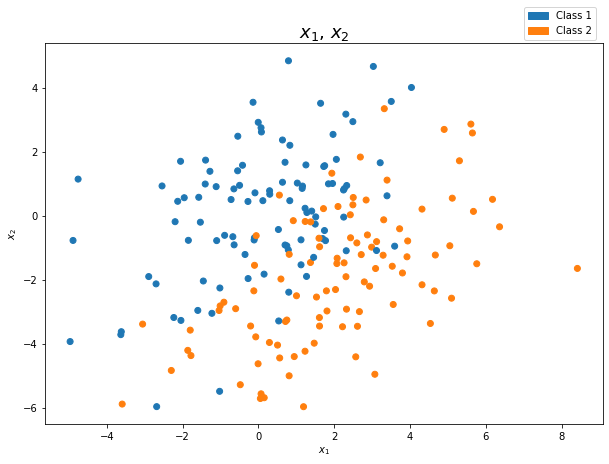

In [3]:
# define color pattern 
color = pd.Series(train_y.flatten()).apply(lambda x: 'C0' if x == 1 else 'C1')
# Create patches for the legend
patches = [ mpatches.Patch(color = 'C0', label = 'Class 1'), mpatches.Patch(color = 'C1', label = 'Class 2') ]


#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(train_x[:,0], train_x[:,1], c=color)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$x_1$, $x_2$', fontsize=18)
_ = ax.legend(handles = patches, \
            loc = 'upper left', bbox_to_anchor=(0.85, 0, 0, 1.11))

## 7.a. Adopt the Bayes classifier.

### 7.a.i. Use the training sete to estimate $P(\omega_1)$ etc...

* the $p(x \vert \omega)$ is calculated in ii

In [4]:
# Parametric approach
gm_1 = GaussianMixture(n_components=1, random_state=0).fit(y_1)
mean_1 = gm_1.means_[0]
cov_1 = gm_1.covariances_[0]
print(mean_1, end='\n'*2)
print(cov_1, end='\n'*2)

# Parametric approach
gm_1 = GaussianMixture(n_components=1, random_state=0).fit(y_2)
mean_2 = gm_1.means_[0]
cov_2 = gm_1.covariances_[0]
print(mean_2, end='\n'*2)
print(cov_2, end='\n'*2)


[0.14549472 0.11840199]

[[3.60099744 1.72386737]
 [1.72386737 4.17836281]]

[ 2.07024339 -1.89136529]

[[4.67059811 2.5746834 ]
 [2.5746834  4.33386385]]



### 7.a.ii. Classify the $x_is$ of the test set

In [5]:
p1 = np.count_nonzero(train_y == 1)/len(train_y)
p2 = 1 - p1

Btest_y = []
for x in test_x:
    cov_norm_1, cov_norm_2 = np.linalg.norm(cov_1)**1/2, np.linalg.norm(cov_2)**1/2
    cov_inv_1, cov_inv_2 = np.linalg.inv(cov_1), np.linalg.inv(cov_2)
    x_mu_1, x_mu_2 = x - mean_1, x - mean_2

    p_x_1 = 1/ ( (2*np.pi) * cov_norm_1 ) * np.exp(-0.5 * (x_mu_1).dot(cov_inv_1).dot((x_mu_1.T)))
    p_x_2 = 1/ ( (2*np.pi) * cov_norm_2 ) * np.exp(-0.5 * (x_mu_2).dot(cov_inv_2).dot((x_mu_2.T)))

    P1_x = p1 * p_x_1 / (p1 * p_x_1 + p2 *p_x_2)
    P2_x = p2 * p_x_2 / (p1 * p_x_1 + p2 *p_x_2)

    if P1_x > P2_x:
        Btest_y.append(1)
    else:
        Btest_y.append(2)

Btest_y = np.array(Btest_y)
df_result = pd.DataFrame(np.hstack((test_x, (Btest_y.reshape(-1,1) - test_y))), columns = ['X1', 'X2', 'y'])
df_result_wrong = df_result[['X1', 'X2']].loc[ df_result.y != 0].to_numpy()

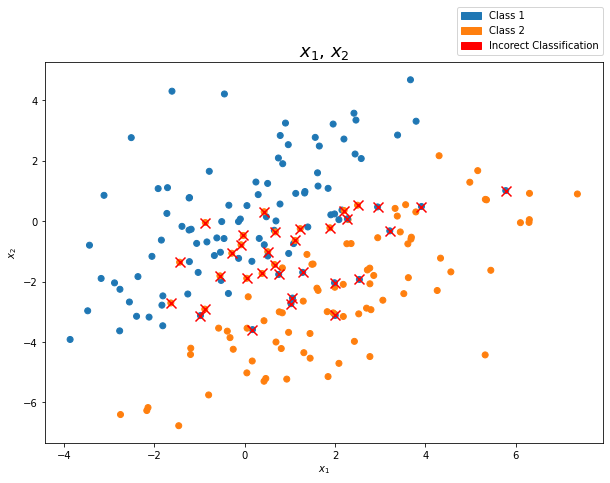

In [6]:
def plot_results(test_y, test_x, df_result_wrong):
    # define color pattern 
    color = pd.Series( test_y.flatten()).apply(lambda x: 'C0' if x == 1 else 'C1')
    # Create patches for the legend
    patches = [ mpatches.Patch(color = 'C0', label = 'Class 1'), mpatches.Patch(color = 'C1', label = 'Class 2'),  
                mpatches.Patch(color = 'r', label = 'Incorect Classification')
                ]


    #plot X data
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax.scatter(test_x[:,0], test_x[:,1], c=color)
    ax.scatter(df_result_wrong[:,0], df_result_wrong[:,1], c='r', marker = 'x', s=100)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('$x_1$, $x_2$', fontsize=18)
    _ = ax.legend(handles = patches, \
                loc = 'upper left', bbox_to_anchor=(0.73, 0, 0, 1.16))
                
plot_results(test_y, test_x, df_result_wrong)                

### 7.a.iii. Estimate the error classification probability

In [7]:
print(f"The ratio of incorectly classified points is:\t {len(df_result_wrong)/len(df_result)}")
print(f"The error classification probability is:\t {1- len(df_result_wrong)/len(df_result)}")


The ratio of incorectly classified points is:	 0.165
The error classification probability is:	 0.835


## 7.b. Adopt the naïve Bayes classifier

### 7.b.i. Use the training set to estimate $P(\omega_1)$ etc...

* the $p(x \vert \omega)$ is calculated in ii

In [8]:
# Clalculate means and variances

## Class 1
mean_11 = y_1[:,0].mean()
mean_12 = y_1[:,1].mean()
s11 = np.power((y_1[:,0]-mean_11), 2).mean()
s12 = np.power((y_1[:,1]-mean_12), 2).mean()
print(mean_11, mean_12)
print(s11, s12, end='\n'*2)

## Class 2
mean_21 = y_2[:,0].mean()
mean_22 = y_2[:,1].mean()
s21 = np.power((y_2[:,0]-mean_21), 2).mean()
s22 = np.power((y_2[:,1]-mean_22), 2).mean()

print(mean_21, mean_22)
print(s21, s22, end='\n'*2)


0.1454947206275725 0.11840199475343569
3.600996439417043 4.17836180522307

2.0702433928758794 -1.8913652876020373
4.670597106503913 4.333862851556329



* knowing that $P(\omega_1) = P(\omega_2) = 0.5$ we can just calculate $g_i(x)$ as $\hat{p}(x \vert \omega_i)$

In [9]:
NBtest_y = []
for x in test_x:
    g_1 = norm.pdf(x[0], loc=mean_11, scale=s11) * norm.pdf(x[1], loc=mean_12, scale=s12)
    g_2 = norm.pdf(x[0], loc=mean_21, scale=s21) * norm.pdf(x[1], loc=mean_21, scale=s21)

    if g_1 > g_2:
        NBtest_y.append(1)
    else:
        NBtest_y.append(2)
NBtest_y = np.array(NBtest_y)
df_result = pd.DataFrame(np.hstack((test_x, (NBtest_y.reshape(-1,1) - test_y))), columns = ['X1', 'X2', 'y'])
df_result_wrong = df_result[['X1', 'X2']].loc[ df_result.y != 0].to_numpy()        

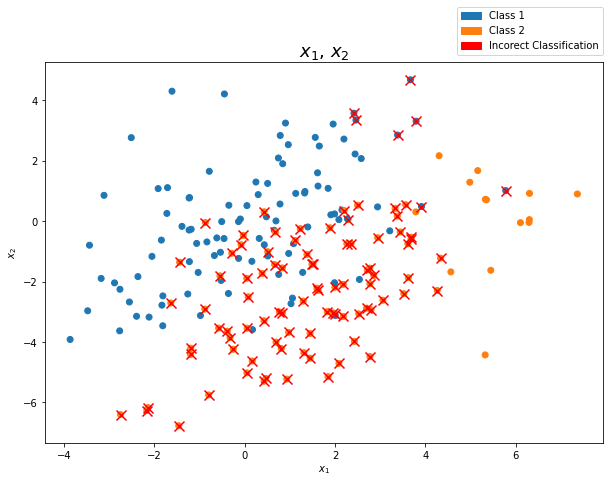

In [10]:
plot_results(test_y, test_x, df_result_wrong)   

### 7.b.iii. Estimate the error classification probability

In [11]:
print(f"The ratio of incorectly classified points is:\t {len(df_result_wrong)/len(df_result)}")
print(f"The error classification probability is:\t {1- len(df_result_wrong)/len(df_result):.3f}")


The ratio of incorectly classified points is:	 0.465
The error classification probability is:	 0.535


## 7.c. Adopt the k-nearest neighbor classifier
 
For $k=5$ and estimate the classification error probability.

The ratio of incorectly classified points is:	 0.17
The error classification probability is:	 0.83


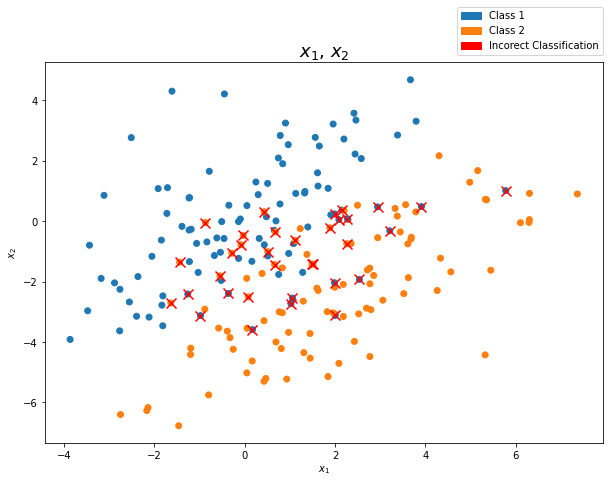

In [12]:
# We will use the default python library
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_x, train_y.ravel())
knntest_y = np.array(neigh.predict(test_x), dtype=int) 

df_result = pd.DataFrame(np.hstack((test_x, (knntest_y.reshape(-1,1) - test_y))), columns = ['X1', 'X2', 'y'])
df_result_wrong = df_result[['X1', 'X2']].loc[ df_result.y != 0].to_numpy()        

plot_results(test_y, test_x, df_result_wrong)   

print(f"The ratio of incorectly classified points is:\t {len(df_result_wrong)/len(df_result)}")
print(f"The error classification probability is:\t {1- len(df_result_wrong)/len(df_result)}")


## 7.d. Adopt the logistic regression classifier

The ratio of incorectly classified points is:	 0.155
The error classification probability is:	 0.845


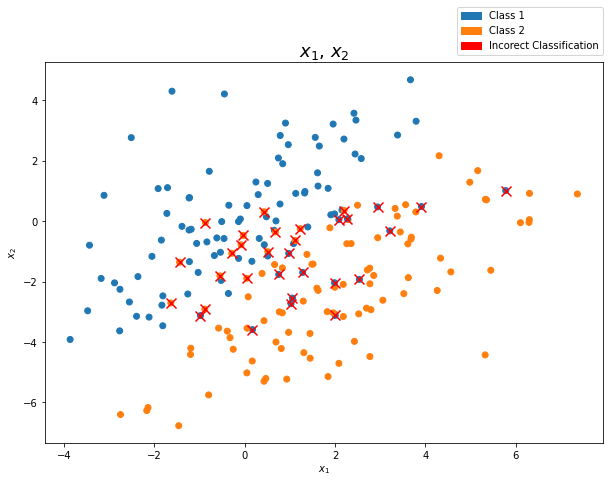

In [13]:

clf = LogisticRegression(random_state=0).fit(train_x, train_y.ravel())
logittest_y = np.array(clf.predict(test_x), dtype=int) 

df_result = pd.DataFrame(np.hstack((test_x, (logittest_y.reshape(-1,1) - test_y))), columns = ['X1', 'X2', 'y'])
df_result_wrong = df_result[['X1', 'X2']].loc[ df_result.y != 0].to_numpy()        

print(f"The ratio of incorectly classified points is:\t {len(df_result_wrong)/len(df_result)}")
print(f"The error classification probability is:\t {1- len(df_result_wrong)/len(df_result)}")


plot_results(test_y, test_x, df_result_wrong)  

## 7.e. Depict graphically the training set, using different colors for points from different classes.

* This graph has been presented previously

## Report the classification results obtained by the four classifiers and comment on them. 

Under what conditions, the first two classifiers would exhibit the same performance?

The results of each classifier are shown in the corresponding graphs, and the misclassified points are highlighted. Looking at the reults we can see that the logistic regression classifier has the best performance, followed by the Bayes classifier and the K-nearest neighbour. Finally we see that the Naive bayes has a sub-par performance. 

The first two classifiers would have the same results if the assumption, that the two samples $x_1$ and $x_2$ are independent was true. In this case the covariance matrix of the Bayes classifier would be diagonal and the expression of the pdf could be expressed in the same manner for both the Naive and typical Bayes classifier.

# Excercise  8

In [14]:
Dataset_a = sio.loadmat('HW9a.mat')

train_x_a = Dataset_a['train_X']
train_y_a = Dataset_a['train_y']
test_x_a = Dataset_a['test_X']
test_y_a = Dataset_a['test_y']



from sklearn import svm


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Part 1

Train the SVM classifier using the training set given above and measure its performance using the test set, using the linear kernel (this corresponds to the linear case presented in the lecture).

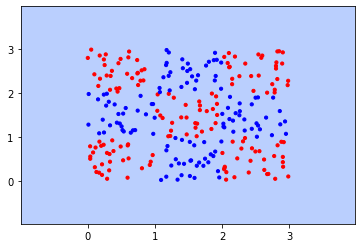

roc_au Score: 50.00%


In [15]:
#select kernel function:{'rbf','poly'}
clf = svm.SVC(kernel='linear',C=10,gamma=1,degree=2)
clf.fit(train_x_a, train_y_a.reshape(270))

X00, X11 = test_x_a[:,0], test_x_a[:,1]
xx, yy = make_meshgrid(X00, X11)
fig, ax= plt.subplots(1, 1)
color= ['red' if l == 1 else 'blue' for l in test_y_a.reshape(270)]
plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.6)
ax.scatter(X00, X11,c=color, cmap=plt.cm.coolwarm, s=10, edgecolors='face')
plt.show()

print(f"roc_au Score: {roc_auc_score(test_y_a, clf.predict(test_x_a).flatten())*100:.2f}%")

* We can see that the linear kernel doesn't have good results. All points are classified as 1 (blue). This is expected, since the data separating our points in not linear.

## Part 2
### RandomizedSearch for the 'rbf' kernel

* We will explore various parameters for the 'rbf' kernel

In [16]:
#select kernel function:{'rbf','poly'}
clf = svm.SVC(random_state=42)
auc = make_scorer(roc_auc_score)

kernel_choice = ['rbf']
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
degree_range = range(0,10)
param_grid = dict(gamma=gamma_range, C=C_range, degree=degree_range, kernel=kernel_choice)   
rand_search = RandomizedSearchCV(clf, param_distributions = param_grid, n_iter = 1000,  scoring = auc, n_jobs=-1, verbose=1)
rand_search.fit(train_x_a, train_y_a.reshape(270)) 
rand_search.best_estimator_            

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1057 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1718 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3553 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.7min finished


SVC(C=10000000.0, degree=4, gamma=0.1, random_state=42)

### Explore the values of C

In [17]:
roc = 0
for C in np.logspace(-2, 10, 13):
    clf = svm.SVC(degree=7, gamma=0.1, random_state=42, C=C)
    clf.fit(train_x_a, train_y_a.reshape(270)) 
    roc_current = roc_auc_score(test_y_a, clf.predict(test_x_a).flatten())*100
    if roc_current > roc:
        best_clf = clf


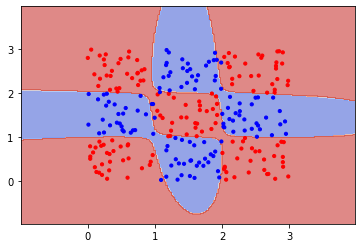

roc_au Score: 96.08%


In [18]:

fig, ax= plt.subplots(1, 1)
color= ['red' if l == 1 else 'blue' for l in test_y_a.reshape(270)]
plot_contours(ax, best_clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.6)
ax.scatter(X00, X11,c=color, cmap=plt.cm.coolwarm, s=10, edgecolors='face')
plt.show()

print(f"roc_au Score: {roc_auc_score(test_y_a, best_clf.predict(test_x_a).flatten())*100:.2f}%")

### RandomizedSearch for the 'poly' kernel

* We will explore various parameters for the 'poly' kernel

In [19]:
#select kernel function:{'rbf','poly'}
clf = svm.SVC(random_state=42)
auc = make_scorer(roc_auc_score)

kernel_choice = ['poly']
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
degree_range = range(0,3)
param_grid = dict(gamma=gamma_range, C=C_range, degree=degree_range, kernel=kernel_choice)   
rand_search = RandomizedSearchCV(clf, param_distributions = param_grid, n_iter = 5,  scoring = auc, n_jobs=-1, verbose=1)
rand_search.fit(train_x_a, train_y_a.reshape(270)) 
rand_search.best_estimator_            

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished


SVC(C=100000000.0, degree=0, gamma=1000.0, kernel='poly', random_state=42)

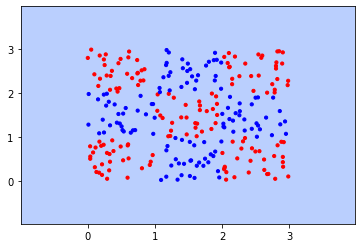

roc_au Score: 50.00%


In [20]:
fig, ax= plt.subplots(1, 1)
color= ['red' if l == 1 else 'blue' for l in test_y_a.reshape(270)]
plot_contours(ax, rand_search, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.6)
ax.scatter(X00, X11,c=color, cmap=plt.cm.coolwarm, s=10, edgecolors='face')
plt.show()

print(f"roc_au Score: {roc_auc_score(test_y_a, rand_search.predict(test_x_a).flatten())*100:.2f}%")

## Commenting

* As shown above the best results are achieved using the 'rbf' kernel, having succesfully separated the majority of the points. On the other hand the 'poly' and 'linear' methods did not fetch satisfying results. While it makes sense for the linear kernel not to fetch satisfying results, we can assume that the reason the 'poly' one did not have good results is due to the complexity. Unfortunately the training time for this kernel is very high, which make it hard to explore the variables (given the limited time we have for each assignment).